<a href="https://colab.research.google.com/github/tusker4/Sesac_Saltlux_Team5/blob/InwooJeong/kaggleEp2iuj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle competitions download -c playground-series-s3e2

playground-series-s3e2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip 'playground-series-s3e2.zip'
# !pip install kaggle
# from google.colab import files
# files.upload()

Archive:  playground-series-s3e2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
# ls -1ha kaggle.json

In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/

In [5]:
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle competitions list

In [7]:
# from google.colab import auth
# auth.authenticate_user()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

train.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0


In [10]:
train.columns

# 설명 참고(https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [11]:
train.shape, test.shape, submission.shape

((15304, 12), (10204, 11), (10204, 2))

In [12]:
train.head(4).T

,0,1,2,3
id,0,1,2,3
gender,Male,Male,Female,Male
age,28.0,33.0,42.0,56.0
hypertension,0,0,0,0
heart_disease,0,0,0,0
ever_married,Yes,Yes,Yes,Yes
work_type,Private,Private,Private,Private
Residence_type,Urban,Rural,Rural,Urban
avg_glucose_level,79.53,78.44,103.0,64.87
bmi,31.1,23.9,40.3,28.8


In [13]:
train.isnull().sum().values
# null값은 없는데 흡연 unknown은 결측치 아닌지?

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
len(train.loc[train['smoking_status']=='Unknown'])

4543

In [15]:
# 학습 시 ID 도 필요 없을 듯
train_df = train.drop('id', axis=1)
train_df.head(4)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0


In [16]:
train_df.shape

(15304, 11)

In [17]:
# 30% 가량 흡연 여부 모름 -> 제거?
# train_df = train[train.smoking_status != 'Unknown']
# train_df.head(4).T

In [18]:
# train_df.shape

# 피처 데이터

In [19]:
def summary_feature_info(df):
  # 인덱스명 그대로 인덱스. 타입은 컬럼으로
  sub_df = pd.DataFrame(df.dtypes, columns=['type'])

  # 피처명도 데이터
  sub_df = sub_df.reset_index()

  # 특정 컬럼명 변경
  sub_df.rename(columns={'index':'feature_name'},inplace=True)

  sub_df['결측치'] = df.isnull().sum().values
  sub_df['고유값'] = df.nunique().values
  sub_df['sample_0'] = df.iloc[0].values
  sub_df['sample_1'] = df.iloc[1].values
  sub_df['sample_2'] = df.iloc[2].values
  return sub_df

summary_feat_df = summary_feature_info(train_df)
summary_feat_df

,feature_name,type,결측치,고유값,sample_0,sample_1,sample_2
0,gender,object,0,3,Male,Male,Female
1,age,float64,0,106,28.0,33.0,42.0
2,hypertension,int64,0,2,0,0,0
3,heart_disease,int64,0,2,0,0,0
4,ever_married,object,0,2,Yes,Yes,Yes
5,work_type,object,0,5,Private,Private,Private
6,Residence_type,object,0,2,Urban,Rural,Rural
7,avg_glucose_level,float64,0,3740,79.53,78.44,103.0
8,bmi,float64,0,407,31.1,23.9,40.3
9,smoking_status,object,0,4,never smoked,formerly smoked,Unknown


In [20]:
train_df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [21]:
len(train_df.loc[train_df['gender']=='Other'])
# 성별 이상한 값 - Other 1개 -> 남자 수가 작으니 남자로

1

In [22]:
train_df.loc[train_df['gender']=='Other','gender'] = 'Male'

In [23]:
train_df['gender'].unique()

array(['Male', 'Female'], dtype=object)

In [24]:
train_df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

# 피처 데이터 타입 별로 묶기
  - bin : gender, hypertension, heart_disease, ever_married, Residence_type
  - num : age, avg_glucose_level, bmi
  - ord : work_type, smoking_status

In [25]:
train_df_arr = train_df[['gender','hypertension','heart_disease','ever_married','Residence_type','age','avg_glucose_level','bmi','work_type','smoking_status','stroke']]

In [26]:
train_df_arr.head(2)

,gender,hypertension,heart_disease,ever_married,Residence_type,age,avg_glucose_level,bmi,work_type,smoking_status,stroke
0,Male,0,0,Yes,Urban,28.0,79.53,31.1,Private,never smoked,0
1,Male,0,0,Yes,Rural,33.0,78.44,23.9,Private,formerly smoked,0


In [27]:
import seaborn as sns

In [28]:
len(train_df_arr.loc[train_df_arr['stroke']==1])

632

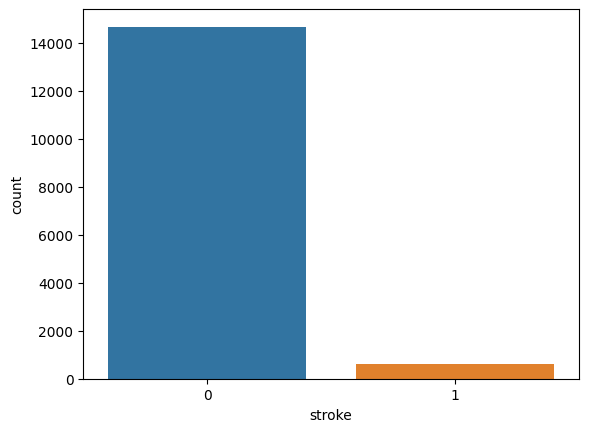

In [29]:
sns.countplot(data=train_df_arr,x='stroke',);

# 0(뇌졸증 x)이 심하게 많음 => 불균형 => 층화 처리 필요?

[95.87036069001567, 4.129639309984317]

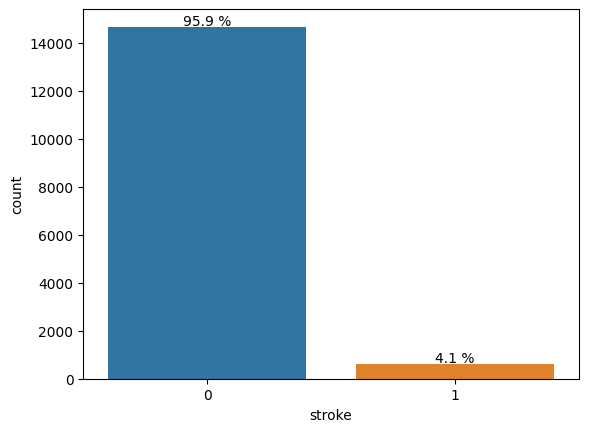

In [30]:
# 향후 계속 사용 가능한 모듈
def draw_text_by_ax( ax, data ):
    '''
        ax:차트의 축정보를 접근가능한 객체
        data:표기할 정보를 계산할 데이터(여기서는 비중 x%)
    '''
    #print( '->', ax.patches )
    percents = list() # 카운트 바 별 비율을 저장할 그릇
    for bar in ax.patches: # 개별 바 정보 접근
        percent = bar.get_height() / data.shape[0] * 100 # 개별카운트/전체데이터수
        # bar를 이용하여 바의 좌표 정보 획득
        ax.text( x = bar.get_x() + bar.get_width()/2,
                 y = bar.get_y() + bar.get_height() + data.shape[0]*0.005,
                 s = f'{percent:1.1f} %',
                 ha= 'center'
                 )
        percents.append( percent )
    # 리턴 : 차트축정보, 비중정보
    return ax, percents

_, rates = draw_text_by_ax( sns.countplot( data=train_df_arr, x='stroke'), train_df_arr )
rates

- 스트로크 0 / 1
  - 0:1 = 95.9:4.1
  - 매우 불균형 - 층화 처리 예상

In [31]:
train_df_arr.columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'age', 'avg_glucose_level', 'bmi', 'work_type',
       'smoking_status', 'stroke'],
      dtype='object')

In [32]:
# len(train_df.columns)

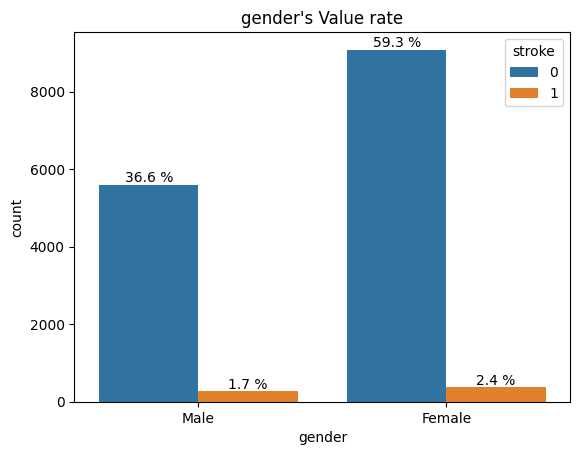

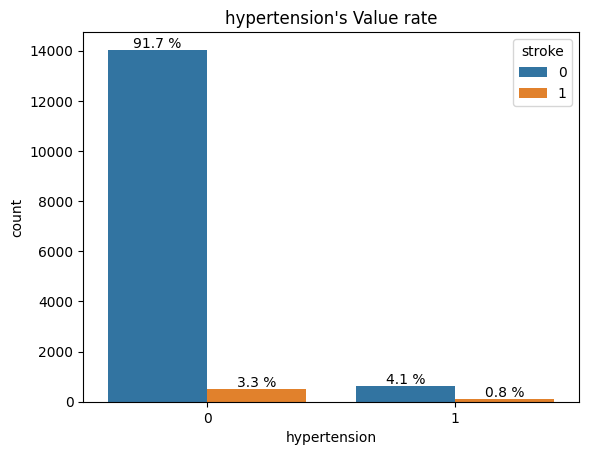

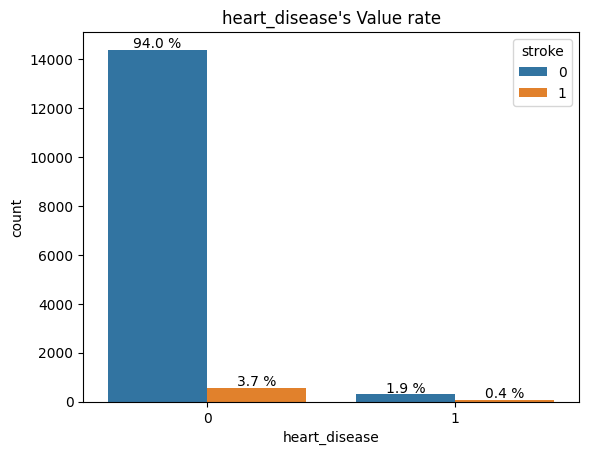

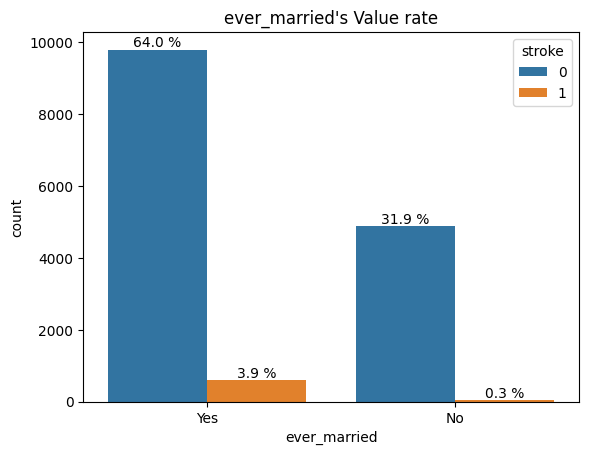

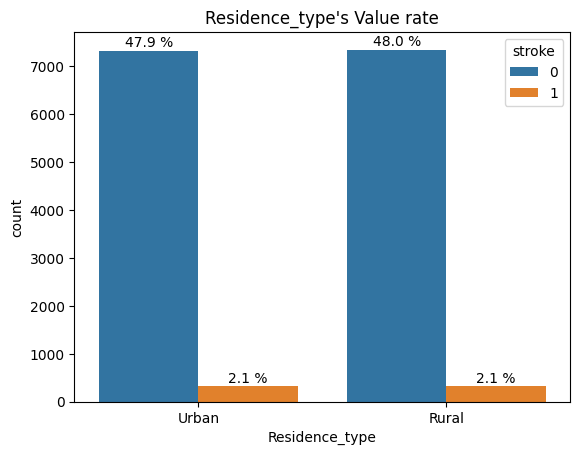

In [33]:
df_logs = dict()

for column in train_df_arr.columns:
  if column not in('age','avg_glucose_level','bmi','stroke','work_type','smoking_status'):
    ax, precents = draw_text_by_ax( sns.countplot( data=train_df_arr, x=column, hue='stroke'), train_df_arr )
    # 퍼센트(피처별 비중) 수집
    df_logs[ column ] = precents
    # 차트 출력
    ax.set_title( f'{column}\'s Value rate' )
    plt.show()

# 차이가 다 많이 남 -> 데이터 구분 시 도움 될 듯 -> 모두 학습에 사용

In [34]:
df_logs

{'gender': [36.55253528489284,
  59.317825405122846,
  1.7250392054364874,
  2.4046001045478307],
 'hypertension': [91.73418714061683,
  4.13617354939885,
  3.293256664924203,
  0.836382645060115],
 'heart_disease': [93.96889702038683,
  1.9014636696288552,
  3.698379508625196,
  0.43125980135912184],
 'ever_married': [63.99634082592787,
  31.87401986408782,
  3.8617354939884994,
  0.2679038159958181],
 'Residence_type': [47.86330371144798,
  48.0070569785677,
  2.0582854155776267,
  2.071353894406691]}

In [35]:
rate_df = pd.DataFrame(df_logs)
rate_df

,gender,hypertension,heart_disease,ever_married,Residence_type
0,36.552535,91.734187,93.968897,63.996341,47.863304
1,59.317825,4.136174,1.901464,31.874020,48.007057
2,1.725039,3.293257,3.698380,3.861735,2.058285
3,2.404600,0.836383,0.431260,0.267904,2.071354


In [36]:
# 0,2 번 -> 각각 고유값에서 스트로크가 0
# 1,3 번 -> 각각 고유값에서 스트로크가 1

rate_df.iloc[0]/rate_df.iloc[2]

gender            21.189394
hypertension      27.855159
heart_disease     25.408127
ever_married      16.571912
Residence_type    23.253968
dtype: float64

## Num 네이터
- age, avg_glucose_level, bmi

In [37]:
train_df_arr.age.nunique(), train_df_arr.avg_glucose_level.nunique(), train_df_arr.bmi.nunique()

(106, 3740, 407)

- bmi, age 너무 많음 -> 묶어서 처리
- 혈당은??? - 100에서 끊기

In [38]:
# 혈당처리 정상범위는 100 미만(구글)
train_df_arr['avg_glucose_level'] = train_df_arr['avg_glucose_level'].apply(lambda x: 1 if x> 100 else 0)

train_df_arr.head(3)

,gender,hypertension,heart_disease,ever_married,Residence_type,age,avg_glucose_level,bmi,work_type,smoking_status,stroke
0,Male,0,0,Yes,Urban,28.0,0,31.1,Private,never smoked,0
1,Male,0,0,Yes,Rural,33.0,0,23.9,Private,formerly smoked,0
2,Female,0,0,Yes,Rural,42.0,1,40.3,Private,Unknown,0


In [39]:
# bmi
'''
Category	BMI (kg/m2)[c]	BMI Prime[c]
Underweight (Severe thinness)	< 16.0	< 0.64
Underweight (Moderate thinness)	16.0 – 16.9	0.64 – 0.67
Underweight (Mild thinness)	17.0 – 18.4	0.68 – 0.73
Normal range	18.5 – 24.9	0.74 – 0.99
Overweight (Pre-obese)	25.0 – 29.9	1.00 – 1.19
Obese (Class I)	30.0 – 34.9	1.20 – 1.39
Obese (Class II)	35.0 – 39.9	1.40 – 1.59
Obese (Class III)	≥ 40.0	≥ 1.60
'''
def chk_bmi(x):
  result = 7

  if x < 16:
    result = 0
  elif x < 17:
    result = 1
  elif x < 18.5:
    result = 2
  elif x < 25:
    result = 3
  elif x < 30:
    result = 4
  elif x < 35:
    result = 5
  elif x < 40:
    result = 6

  return result

train_df_arr['bmi'] = train_df_arr['bmi'].apply(chk_bmi)
train_df_arr.head()

,gender,hypertension,heart_disease,ever_married,Residence_type,age,avg_glucose_level,bmi,work_type,smoking_status,stroke
0,Male,0,0,Yes,Urban,28.0,0,5,Private,never smoked,0
1,Male,0,0,Yes,Rural,33.0,0,3,Private,formerly smoked,0
2,Female,0,0,Yes,Rural,42.0,1,7,Private,Unknown,0
3,Male,0,0,Yes,Urban,56.0,0,4,Private,never smoked,0
4,Female,0,0,No,Rural,24.0,0,4,Private,never smoked,0


In [40]:
# age

def chk_age(x):
  result = 8

  if x < 10:
    result = 0
  elif x < 20:
    result = 1
  elif x < 30:
    result = 2
  elif x < 40:
    result = 3
  elif x < 50:
    result = 4
  elif x < 60:
    result = 5
  elif x < 70:
    result = 6
  elif x < 80:
    result = 7

  return result

train_df_arr['age'] = train_df_arr['age'].apply(chk_age)
train_df_arr.head()

,gender,hypertension,heart_disease,ever_married,Residence_type,age,avg_glucose_level,bmi,work_type,smoking_status,stroke
0,Male,0,0,Yes,Urban,2,0,5,Private,never smoked,0
1,Male,0,0,Yes,Rural,3,0,3,Private,formerly smoked,0
2,Female,0,0,Yes,Rural,4,1,7,Private,Unknown,0
3,Male,0,0,Yes,Urban,5,0,4,Private,never smoked,0
4,Female,0,0,No,Rural,2,0,4,Private,never smoked,0


In [41]:
train_df_arr['work_type'].unique() , train_df_arr['smoking_status'].unique()

(array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
       dtype=object),
 array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
       dtype=object))

In [42]:
# ever_married y 0/ n 1       resi u 0 / r 1

train_df_arr['ever_married'] = train_df_arr['ever_married'].map({'Yes':0, 'No':1})
train_df_arr['Residence_type'] = train_df_arr['Residence_type'].map({'Urban':0, 'Rural':1})

# smoke
smoke_mapping = {'Unknown':0,'never smoked':1,'formerly smoked':2,'smokes':3}

# work - 스트레스 덜 받는 순?
work_mapping = {'children':0,'Govt_job':1,'Self-employed':2,'Private':3,'Never_worked':4}

train_df_arr['work_type'] = train_df_arr['work_type'].map(work_mapping)
train_df_arr['smoking_status'] = train_df_arr['smoking_status'].map(smoke_mapping)

In [43]:
train_df_arr['gender'] = train_df_arr['gender'].map({'Male':0, 'Female':1})

In [44]:
train_df_arr.columns

Index(['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'age', 'avg_glucose_level', 'bmi', 'work_type',
       'smoking_status', 'stroke'],
      dtype='object')

In [45]:
train_df_arr

,gender,hypertension,heart_disease,ever_married,Residence_type,age,avg_glucose_level,bmi,work_type,smoking_status,stroke
0,0,0,0,0,0,2,0,5,3,1,0
1,0,0,0,0,1,3,0,3,3,2,0
2,1,0,0,0,1,4,1,7,3,0,0
3,0,0,0,0,0,5,0,4,3,1,0
4,1,0,0,1,1,2,0,4,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,1,0,0,1,0,2,0,3,1,1,0
15300,1,1,0,0,0,4,1,5,3,1,0
15301,1,0,0,0,0,7,0,4,2,1,0
15302,0,0,0,0,1,4,1,3,3,0,0


In [46]:
train = train.drop('id', axis=1)

In [47]:
test = test.drop('id', axis=1)

In [48]:
# 성별
train['gender'] = train['gender'].apply(lambda x: 1 if x =='Female' else 0)
test['gender'] = test['gender'].apply(lambda x: 1 if x =='Female' else 0)

In [49]:
# 나이
train['age'] = train['age'].apply(chk_age)
test['age'] = test['age'].apply(chk_age)

In [50]:
# 결혼
train['ever_married'] = train['ever_married'].map({'Yes':0, 'No':1})
test['ever_married'] = test['ever_married'].map({'Yes':0, 'No':1})

In [51]:
# 일
train['work_type'] = train['work_type'].map(work_mapping)
test['work_type'] = test['work_type'].map(work_mapping)

In [52]:
# 주거
train['Residence_type'] = train['Residence_type'].map({'Urban':0, 'Rural':1})
test['Residence_type'] = test['Residence_type'].map({'Urban':0, 'Rural':1})

In [53]:
# 혈당
train['avg_glucose_level'] = train['avg_glucose_level'].apply(lambda x: 1 if x> 100 else 0)
test['avg_glucose_level'] = test['avg_glucose_level'].apply(lambda x: 1 if x> 100 else 0)

In [54]:
# bmi
train['bmi'] = train['bmi'].apply(chk_bmi)
test['bmi'] = test['bmi'].apply(chk_bmi)

In [55]:
# 흡연
train['smoking_status'] = train['smoking_status'].map(smoke_mapping)
test['smoking_status'] = test['smoking_status'].map(smoke_mapping)

In [56]:
test.shape, train.shape

((10204, 10), (15304, 11))

In [57]:
train_test_df = pd.concat([train, test],ignore_index=True)
train_test_df.shape

(25508, 11)

In [58]:
train_test_df.iloc[train.shape[0]-1: train.shape[0]+1]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
15303,1,1,0,0,1,3,1,0,3,1,0.0
15304,1,5,0,0,0,3,1,0,5,0,NaN


In [59]:
X_sub = train_test_df[pd.isnull(train_test_df['stroke'])]  # 정답 없는 것들
X_sub.shape

(10204, 11)

In [60]:
X = train_test_df[~pd.isnull(train_test_df['stroke'])]  # 정답 있는 것들
X.shape

(15304, 11)

In [61]:
y = X['stroke']
X = X.drop(['stroke'],axis=1)

X_sub = X_sub.drop(['stroke'], axis=1)

In [62]:
X.shape, y.shape, X_sub.shape

((15304, 10), (15304,), (10204, 10))

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11478, 10), (3826, 10), (11478,), (3826,))

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

clf = LogisticRegression()

grid_params = {
    'C'           :[0.001, 0.01, 0.1, 0.125, 1], # 과적합 방지 규제 강도, 높을수록 강하다. L1, L2
    'max_iter'    :[600, 700, 800, 900 ], # 모델 성능을 높이기 위해 학습의 반복 회수
    'solver'     :['liblinear'],        # 과적합 방지용 L1, L2 모두 지원
    'random_state':[0, 42, 100]     # 난수시드
}

In [65]:
model = GridSearchCV( clf, grid_params, scoring='roc_auc', cv=5)

In [67]:
model.fit( X_train, y_train )

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.125, 1],
                         'max_iter': [600, 700, 800, 900],
                         'random_state': [0, 42, 100],
                         'solver': ['liblinear']},
             scoring='roc_auc')

In [68]:
model.best_params_, model.best_score_

({'C': 1, 'max_iter': 600, 'random_state': 0, 'solver': 'liblinear'},
 0.8822162365167262)

In [78]:
from sklearn.metrics import roc_auc_score

y_pred = model.best_estimator_.predict_proba( X_test )[ :, 1]

roc_auc_score(y_test,y_pred) # 모델 성능값과 비교해서 과적합 판단

0.8719070144614137

In [76]:
y_pred.shape, submission.shape, X_test.shape

((3826,), (10204, 2), (3826, 10))

In [79]:
# 제출용 테스트 데이터 제출파일 생성
# 값을 세팅
submission['stroke'] = model.best_estimator_.predict_proba( X_sub )[ :, 1]
# kaggle에 제출할 파일 생성
submission.to_csv( 'mlpro_ver1.csv', index=False )